# Assignment for brain

## 1. Data Exploration

### Package imports.

- nibabel: visualization

In [1]:
import os
import glob
import seaborn as sns
import re
import pandas as pd
# For excel reading, also install openpyxl
import numpy as np
import torch
# from sklearn.model_selection import train_test_split
import nibabel as nib
import matplotlib.pyplot as plt


### Constants

- `BASE_PATH`: The location of the image files and excel file
- `EXCLUDED_IDS`: Patients to be excluded (according to the thesis document)

In [2]:
BASE_PATH = 'Data/'

# For the TCIA LOCATIONS
TCIA_IMG_SUFFIX = '_PV.nii.gz'
TCIA_LOCATION = BASE_PATH + 'TCIA/'
TCIA_IMG_PATH = TCIA_LOCATION + 'TCIA_image_PV/'
TCIA_RESULTS_PATH = TCIA_LOCATION + 'TCIA_results_phase_PV/'
TCIA_EXCEL = TCIA_LOCATION + 'HCC-TACE-Seg_clinical_data-V2.xlsx'

# For the OP locations
OP_LOCATION = BASE_PATH + 'OP/'
NIFTI_PATH = OP_LOCATION + 'OP_C+P_nifti'
NNU_NET_PATH = OP_LOCATION + 'OP_C+P_nnUnet'
OP_EXCEL = OP_LOCATION + 'OP_申請建模_1121110_20231223.xlsx'
OP_WILDCARD = '*_VENOUS_PHASE.nii.gz'
OP_SEG_WILDCARD = '*_VENOUS_PHASE_seg.nii.gz'

EXCLUDED_IDS = ['HCC_048', 'HCC_001', 'HCC_006', 'HCC_015', 'HCC_016',
                'HCC_041', 'HCC_082', 'HCC_085', 'HCC_089', 'HCC_0959']

### Data exploration 

In [3]:
data = pd.read_excel(TCIA_EXCEL)

In [4]:
data.head()

,TCIA_ID,Interval_BL,Interval_FU,TTP,Death_1_StillAliveorLostToFU_0,Censored_0_progressed_1,OS,hepatitis,age,agegp,...,3_RECIST,1_mRECIST_BL,1_mRECIST_FU,1_mRECIST,2_mRECIST_BL,2_mRECIST_FU,2_mRECIST,3_mRECIST_BL,3_mRECIST_FU,3_mRECIST
0,HCC_001,-18,20.43,197.000000,1,1,350.285714,HCV only,71,>70,...,3.0,44.5,0.0,1.0,43.0,0.0,1.0,43.0,0.0,1.0
1,HCC_002,84,22.86,20.714286,1,0,25.285714,HBV only,72,>70,...,3.0,103.7,58.6,2.0,107.0,69.0,2.0,106.0,58.6,2.0
2,HCC_003,3,7.00,5.571429,1,1,21.428571,HCV only,53,51-60,...,3.0,162.2,173.9,3.0,87.0,127.0,4.0,127.0,138.0,3.0
3,HCC_004,1,7.57,5.428571,1,0,10.285714,No virus,80,>70,...,3.0,70.8,70.8,3.0,65.0,44.0,2.0,65.0,50.9,3.0
4,HCC_005,435,13.86,12.857143,1,0,56.285714,No virus,73,>70,...,3.0,70.2,62.1,3.0,67.0,62.0,3.0,63.3,68.2,3.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TCIA_ID                         105 non-null    object 
 1   Interval_BL                     105 non-null    int64  
 2   Interval_FU                     97 non-null     float64
 3   TTP                             105 non-null    float64
 4   Death_1_StillAliveorLostToFU_0  105 non-null    int64  
 5   Censored_0_progressed_1         105 non-null    int64  
 6   OS                              105 non-null    float64
 7   hepatitis                       105 non-null    object 
 8   age                             105 non-null    int64  
 9   agegp                           105 non-null    object 
 10  Sex                             105 non-null    int64  
 11  Smoking                         105 non-null    int64  
 12  Alcohol                         105 

In [6]:
data['TCIA_ID'][:5]

0    HCC_001
1    HCC_002
2    HCC_003
3    HCC_004
4    HCC_005
Name: TCIA_ID, dtype: object

In [7]:
data['TCIA_ID'].count()

105

In [8]:
'Unique ids: %d' % data['TCIA_ID'].value_counts().shape[0]

'Unique ids: 105'

Some files are not present. Let's remove them from the dataset

In [4]:
def img_join(id):
    return os.path.join(TCIA_IMG_PATH, id + TCIA_IMG_SUFFIX)

def results_join(id):
    return os.path.join(TCIA_RESULTS_PATH, id + TCIA_IMG_SUFFIX)

data['img_path'] = data['TCIA_ID'].apply(img_join)
data['result_path'] = data['TCIA_ID'].apply(results_join)

print(data.shape[0])
data[['TCIA_ID', 'img_path', 'result_path']].head()

105


,TCIA_ID,img_path,result_path
0,HCC_001,Data/TCIA/TCIA_image_PV/HCC_001_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_001_PV.nii.gz
1,HCC_002,Data/TCIA/TCIA_image_PV/HCC_002_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_002_PV.nii.gz
2,HCC_003,Data/TCIA/TCIA_image_PV/HCC_003_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_003_PV.nii.gz
3,HCC_004,Data/TCIA/TCIA_image_PV/HCC_004_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_004_PV.nii.gz
4,HCC_005,Data/TCIA/TCIA_image_PV/HCC_005_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_005_PV.nii.gz


In [5]:
def file_exists(file_path):
    exists = os.path.exists(file_path)
    if not exists:
        print('WARN: File not found: %s' % file_path)
    return exists

original = len(data)
data = data[data['result_path'].apply(file_exists)]

print('%d files not found' % (original - len(data)))

WARN: File not found: Data/TCIA/TCIA_results_phase_PV/HCC_008_PV.nii.gz
WARN: File not found: Data/TCIA/TCIA_results_phase_PV/HCC_011_PV.nii.gz
WARN: File not found: Data/TCIA/TCIA_results_phase_PV/HCC_031_PV.nii.gz
WARN: File not found: Data/TCIA/TCIA_results_phase_PV/HCC_082_PV.nii.gz
4 files not found


Remove stages data

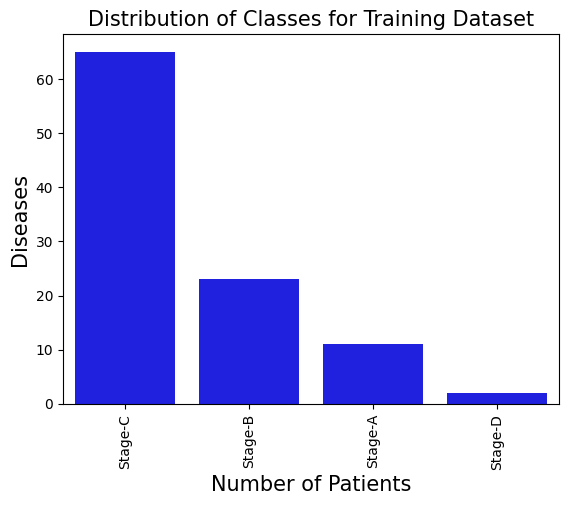

In [6]:
dist = data['BCLC'].value_counts()

sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of Classes for Training Dataset', fontsize=15)
plt.xlabel('Number of Patients', fontsize=15)
plt.ylabel('Diseases', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [7]:
before = len(data)
data = data[data['BCLC'] != 'Stage-D']

print('Removed %d elements' % (before - len(data)))

Removed 2 elements


### Data visualization

Display the first available image

**Original**

Load the data

In [8]:
# Load the .nii.gz file
img = nib.load(data.iloc[0]['img_path'])

# Get the image data
img_data = img.get_fdata()

img_data.shape

(512, 512, 36)

In [12]:
def display_image(img_data, index):
    plt.imshow(img_data[:, :, index], cmap='gray')
    plt.axis('off')
    plt.colorbar()
    plt.title('Raw liver image. Slice %d' % index)
    plt.show()

Display the first slice

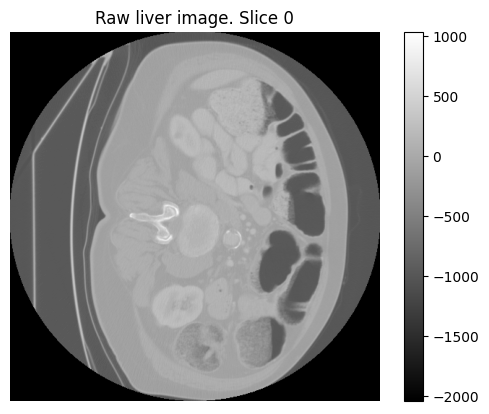

In [13]:
display_image(img_data, 0)

Medium slice

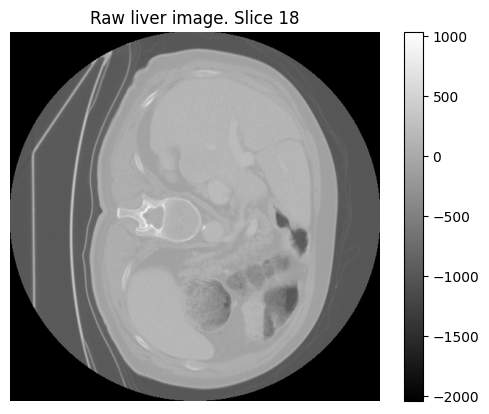

In [14]:
display_image(img_data, img_data.shape[2] // 2)

Last slice

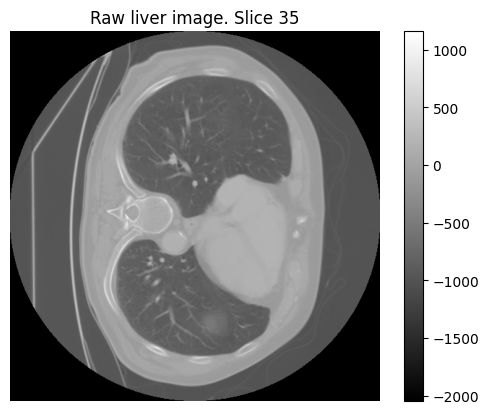

In [16]:
display_image(img_data, img_data.shape[2] - 1)

**Mask**

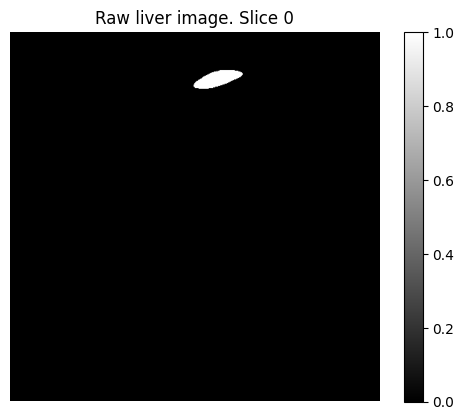

In [18]:
# Load the .nii.gz file
img = nib.load(data.iloc[0]['result_path'])

# Get the image data
img_data = img.get_fdata()

display_image(img_data, 0)


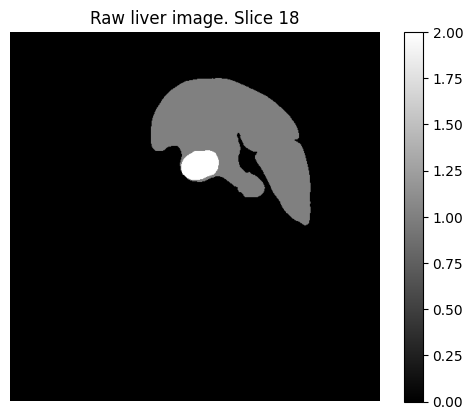

In [19]:
display_image(img_data, img_data.shape[2] // 2)

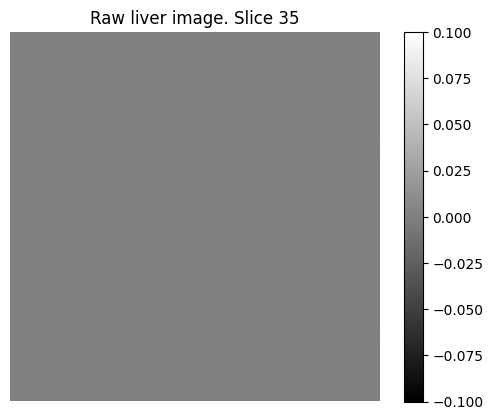

In [20]:
display_image(img_data, img_data.shape[2] - 1)

### Display random images

In [28]:
# Extract 9 random images
random_images = np.random.choice(len(data), size=4, replace=False)

random_images

array([28, 83, 25, 99])

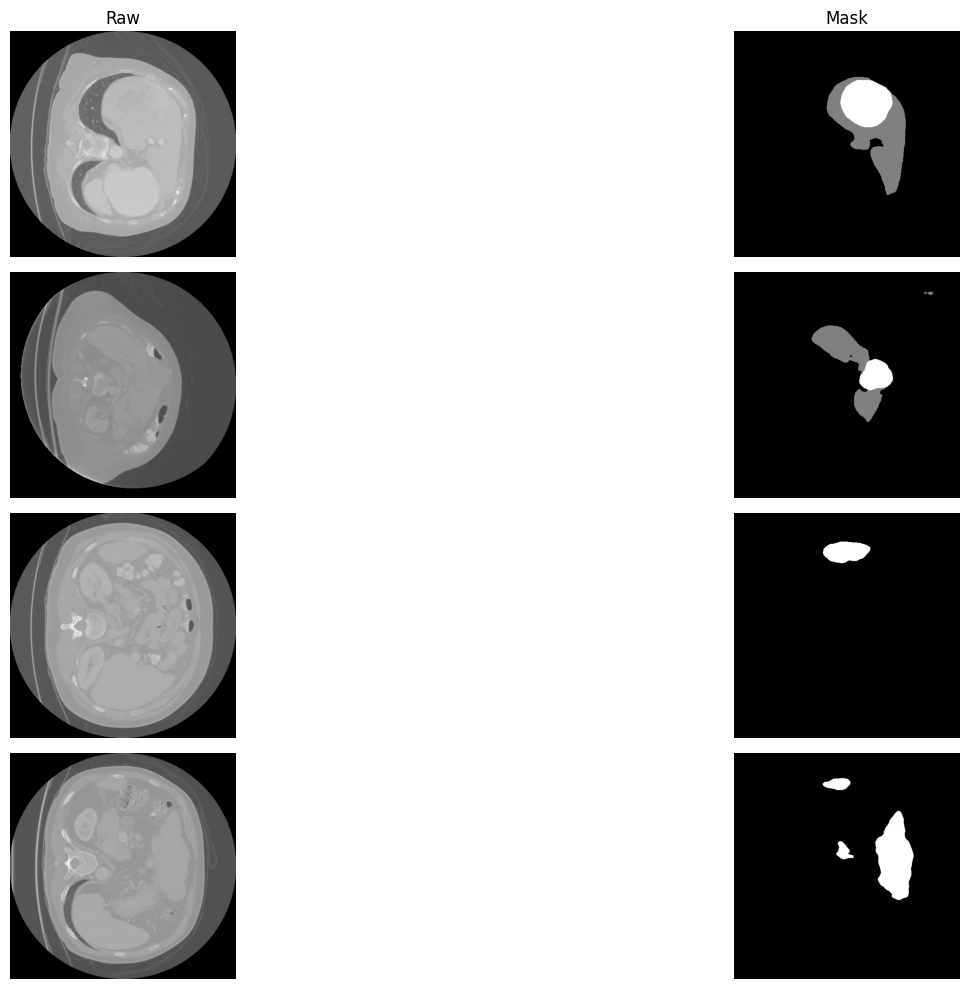

In [43]:
plt.figure(figsize=(20,10))

def display_img(img_path, pos):
    plt.subplot(4, 2, pos)
    if pos == 1:
        plt.title('Raw')
    elif pos == 2:
        plt.title('Mask')
    img = nib.load(img_path)
    img_data = img.get_fdata()
    plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')
    plt.axis('off')

for i in range(len(random_images)):
    # Load the .nii.gz file
    display_img(data.iloc[random_images[i]]['img_path'], i + (i + 1))
    display_img(data.iloc[random_images[i]]['result_path'], i + (i + 2))

plt.tight_layout()

![Dog Meme](https://i.pinimg.com/474x/81/9d/5d/819d5df2b9b8798e21aa5fc1becec80a--number--dog-memes.jpg)


## Training

In [48]:
mapping = {'Stage-A': 0, 'Stage-B': 1, 'Stage-C': 2}
map_series = data['BCLC'].map(mapping)

In [50]:
training_df = data[['img_path', 'result_path']]

training_df['class'] = map_series

training_df.head()

/tmp/ipykernel_92694/582213865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['class'] = map_series


,img_path,result_path,class
0,Data/TCIA/TCIA_image_PV/HCC_001_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_001_PV.nii.gz,0
1,Data/TCIA/TCIA_image_PV/HCC_002_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_002_PV.nii.gz,2
2,Data/TCIA/TCIA_image_PV/HCC_003_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_003_PV.nii.gz,2
3,Data/TCIA/TCIA_image_PV/HCC_004_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_004_PV.nii.gz,1
4,Data/TCIA/TCIA_image_PV/HCC_005_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_005_PV.nii.gz,2


In [51]:
len(training_df)

99